In [3]:
!pip install scikit-learn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


#### 介绍数据集

1. 在 plt.plot_digits(some_digit_image, cmap='binary') 这行代码中，cmap 参数用于指定颜色映射（Colormap），它决定了图像中像素值如何映射到颜色上。具体来说：
    - cmap 是 colormap（颜色映射） 的缩写。它定义了一组颜色，用于将数据值转换为图像中的颜色显示。
    - 作用：当你使用 plt.plot_digits 显示图像时，图像的每个像素都有一个数值（通常是灰度值或强度值）。cmap 决定了这些数值如何被转换为具体的颜色，以便在图像中呈现出来。
    - cmap='binary' 的含义：
        - 'binary' 是一种黑白二值的颜色映射。它将较低的数值映射为黑色，较高的数值映射为白色，适用于显示灰度图像或二值图像。
    效果：
        - 使用 'binary' 可以清晰地展示图像的亮暗对比，适合展示手写数字、简单图形等
    - **matplotlib颜色**： https://matplotlib.net.cn/stable/users/explain/colors/colormaps.html

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1,parser="auto")
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
# 每张图片有784个特征
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Name: 0, Length: 784, dtype: int64


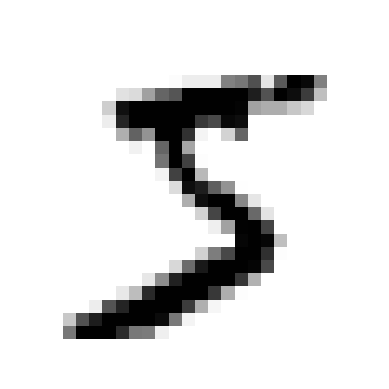

5


In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

print(X.iloc[0]) # 获取第一行数据 为pandas的series
some_digit = X.iloc[0].values
some_digit_imamge = some_digit.reshape(28,28)

plt.imshow(some_digit_imamge, cmap='binary')
plt.axis('off')
plt.show()

print(y[0])

1. 注意标签是字符，大部分机器学习算法希望是数字，让我们把y转换成整数

In [7]:
import numpy as np
y = y.astype(np.uint8)

#### 创建训练集和测试集

In [8]:
X_train, X_test, y_train, y_test = X[:6000],X[6000:],y[:6000],y[6000:]

#### 训练二元分类器

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

1. SGDClassifier在训练时是完全随机的（因此得名“随机”​）​，如果你希望得到可复现的结果，需要设置参数random_state

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train_5)

SGDClassifier()

In [11]:
sgd_clf.predict([some_digit])

c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([False])

#### 性能测量
1. 评估分类器比评估回归器要困难得多
2. 准确率通常无法成为分类器的首要性能指标，特别是当你处理有偏数据集时（即某些类比其他类更为频繁），比如猜数字是5还是不是5， 有90%的数字都不是5，所以只要一直猜不是5，都有90%的正确率

##### 使用交叉验证测量准确率
1. 每个折叠由StratifiedKFold执行分层抽样

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]

    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.96
0.9655
0.965


In [13]:
# 使用内置的函数
from sklearn.model_selection import cross_val_score

scores = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

print(f"Cross-Validation Accuracy Scores: {scores}")
print(f"Average Cross-Validation Accuracy: {scores.mean():.2%}")

Cross-Validation Accuracy Scores: [0.9405 0.95   0.9565]
Average Cross-Validation Accuracy: 94.90%


#### 混淆矩阵
1. 评估分类器性能的更好方法是混淆矩阵，其总体思路就是统计A类别实例被分成为B类别的次数。例如，要想知道分类器将数字3和数字5混淆多少次，只需要通过混淆矩阵的第5行第3列来查看
2. 与cross_val_score（​）函数一样，cross_val_predict（​）函数同样执行K-折交叉验证，但返回的不是评估分数，而是每个折叠的预测。这意味着对于每个实例都可以得到一个干净的预测（​“干净”的意思是模型预测时使用的数据在其训练期间从未见过）​。

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[5342,  144],
       [ 107,  407]], dtype=int64)

##### 精度
1. 正类预测的准确率是一个有意思的指标，它也称为分类器的精度
2. 精度 = TP /（TP + FP） -- TP是真正类的数量，FP是假正类的数量

##### 召回率
1. 召回率 = TP / （TP + FN） -- FN是假负类的数量

 <img src="./images/分类模型混淆矩阵.png" width="500" height="500">

##### 精度和召回率

1. 只有80%的概率是准确的，并且也只有74.7%的数字5被它检测出来了。
2. 精度和召回率组合成一个单一的指标，称为F1分数
3. 在某些情况下，你更关心的是精度，而另一些情况下，你可能真正关心的是召回率。例如，假设你训练一个分类器来检测儿童可以放心观看的视频，那么你可能更青睐那种拦截了很多好视频（低召回率）​，但是保留下来的视频都是安全（高精度）的分类器

<img src='./images/F1score.png' width='1000' height='350'>

In [16]:
from sklearn.metrics import precision_score, recall_score


print(f"precision: {precision_score(y_train_5, y_train_pred)}")
print(f"recall score: {recall_score(y_train_5, y_train_pred)}")

precision: 0.7386569872958257
recall score: 0.791828793774319


In [17]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7643192488262911

##### 精度和召回率权衡
1. SGDClassifier如何进行分类决策。对于每个实例，它会基于决策函数计算出一个分值，如果该值大于阈值，则将该实例判为正类，否则便将其判为负类。
2. Scikit-Learn不允许直接设置阈值，但是可以访问它用于预测的决策分数。不是调用分类器的predict（​）方法，而是调用decision_function（​）方法。

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[-14049.19197311]
[False]


c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


1. 使用`cross_val_predict（​）`函数获取训练集中所有实例的分数，但是这次需要它返回的是**决策分数**而不是预测结果：

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [20]:
from sklearn.metrics import precision_recall_curve

precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
print("precision: ",precision)
print("recalls: ",recalls)
print("thresholds: ",thresholds)

precision:  [0.08566667 0.08568095 0.08569523 ... 1.         1.         1.        ]
recalls:  [1.         1.         1.         ... 0.00389105 0.00194553 0.        ]
thresholds:  [-3675362.43980431 -3257523.21332688 -3229664.40050749 ...
   951762.36795298  1026992.81781814  1069203.93651551]


1. 使用Matplotlib绘制精度和召回率相对于阈值的函数图

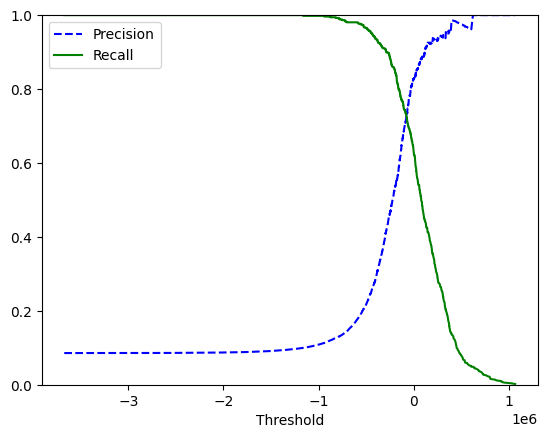

In [21]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plot_precision_recall_vs_threshold(precision, recalls, thresholds)
plt.show()

In [22]:
# 找到精度大于等于90%的最低阈值
thresholds_90_precision = thresholds[np.argmax(precision >= 0.90)]
print(thresholds_90_precision)

118778.07483146629


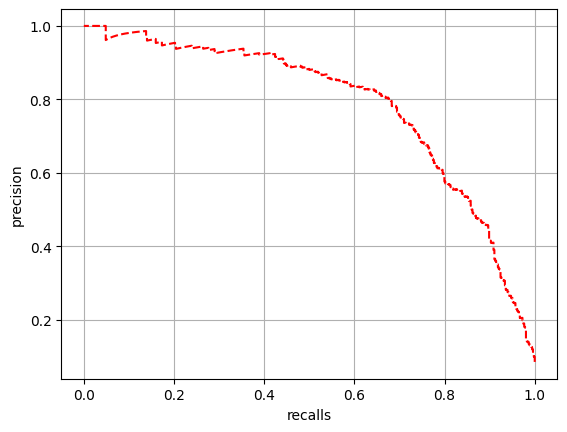

In [23]:
plt.plot(recalls, precision, '--r')
plt.xlabel('recalls')
plt.ylabel('precision')
plt.grid()
plt.show()

In [24]:
y_train_pred_90 = (y_scores >= thresholds_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9011857707509882

In [25]:
recall_score(y_train_5, y_train_pred_90)

0.44357976653696496

如果有人说：​“我们需要99%的精度。​”你就应该问：​“召回率是多少？​”

#### ROC曲线
1. 正确分类成功和正确分类失败的关系
2. 一个优秀的分类器应该离这条线越远越好（向左上角移动）
3. 横轴 (X-axis: False Positive Rate, FPR)：
    - False Positive Rate (FPR) 表示误报率，即将负类错误地预测为正类的比例。它是FP / (FP + TN)，其中FP是假阳性，TN是真阴性。在这条轴上，值越小越好，表示误报越少。
4. 纵轴 (Y-axis: True Positive Rate, TPR)：
    - True Positive Rate (TPR)，也叫敏感度或召回率，表示将正类正确预测为正类的比例。它是TP / (TP + FN)，其中TP是真阳性，FN是假阴性。在这条轴上，值越大越好，表示更高的召回率。

In [26]:

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

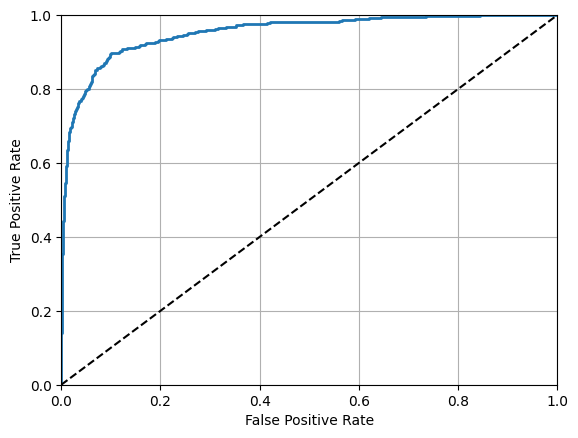

In [27]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
plot_roc_curve(fpr, tpr)
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9541716374613272

#### 使用RandomForest分类器

1. RandomForestClassifier类没有decision_function（​）方法，相反，它有dict_proba（​）方法。Scikit-Learn的分类器通常都会有这两种方法中的一种（或两种都有）​。

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

1. 在计算ROC曲线时，我们需要**对每个阈值**计算TPR和FPR。通常情况下，我们使用模型预测的概率值作为阈值。这是因为概率值可以反映模型对样本的 confidence，从而更好地评估模型在不同阈值下的性能。

2. y_scores_forest是模型预测的概率值，因此可以直接用于计算ROC曲线。总之，使用概率值计算ROC曲线的原因是，概率值可以反映模型对样本的 confidence，从而更好地评估模型在不同阈值下的性能。

In [30]:
y_scores_forest = y_probas_forest[:,1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

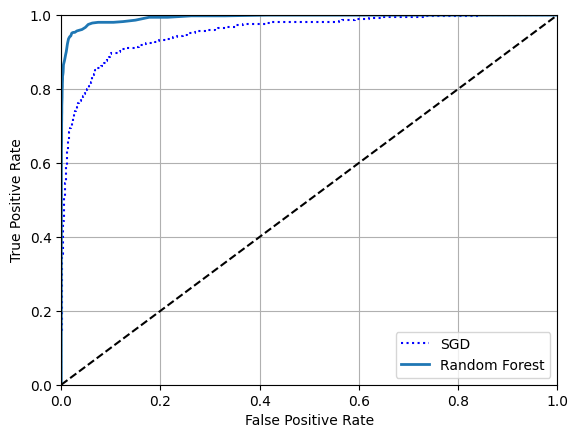

In [31]:
plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [32]:
roc_auc_score(y_train_5, y_scores_forest)

0.9936162229715256

In [33]:
y_forest_bool = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict')

In [34]:
precision_score(y_train_5, y_forest_bool)

0.9886363636363636

In [35]:
recall_score(y_train_5, y_forest_bool)

0.6770428015564203

### 多类分类器

1. 一种方法是训练10个二元分类器，每个数字一个（0-检测器、1-检测器、2-检测器，以此类推）​。
2. 当你需要对一张图片进行检测分类时，获取每个分类器的决策分数，哪个分类器给分最高，就将其分为哪个类。这称为一对剩余（OvR）策略，也称为一对多（one-versus-all）​。
3. 另一种方法是为每一对数字训练一个二元分类器：一个用于区分0和1，一个区分0和2，一个区分1和2，以此类推。这称为一对一（OvO）策略。如果存在N个类别，那么这需要训练N×（N-1）/2个分类器
4. OvO的主要优点在于，每个分类器只需要用到**部分训练集**对其必须区分的两个类进行训练且速度大
5. Scikit-Learn可以检测到你尝试使用二元分类算法进行多类分类任务，它会根据情况自动运行OvR或者OvO

Scikit-Learn实际上训练了45个二元分类器，获得它们对图片的决策分数，然后选择了分数最高的类。

In [36]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])


c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [37]:
some_digit_scores = svm_clf.decision_function([some_digit])
print(some_digit_scores)

[[ 1.74201669  3.75934047  6.18134457  8.29644372 -0.30252035  9.30527336
   1.74930094  2.77838477  7.19221016  3.87315474]]


c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [38]:
sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.856, 0.877, 0.865])

将输入进行简单缩放（如第2章所述归一化）可以将准确率提到89%以上：

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8685, 0.896 , 0.8905])

#### 误差分析

1. 如果这是一个真正的项目，你将遵循机器学习项目清单中的步骤（见附录B）​：探索数据准备的选项，尝试多个模型，列出最佳模型并用GridSearchCV对其超参数进行微调，尽可能自动化，等等。正如你在之前的章节里尝试的那些。在这里，假设你已经找到了一个有潜力的模型，现在你希望找到一些方法对其进一步改进。方法之一就是分析其**错误类型**

In [40]:
sgd_clf.decision_function([some_digit])

c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-1012918.23834083,  -490516.21089758,  -398181.42077246,
          -17976.94046638,  -595689.83476232,   -15779.38046973,
         -537908.78382641,  -616095.02314662,  -289676.09345707,
         -381239.03760726]])

In [41]:
y_train

0       5
1       0
2       4
3       1
4       9
       ..
5995    7
5996    6
5997    8
5998    6
5999    9
Name: class, Length: 6000, dtype: uint8

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict

X, y = mnist['data'], mnist['target']
# 2. 转换标签为整数类型
y = y.astype(np.int8)

# 3. 拆分数据集为训练集和测试集（例如，70% 训练，30% 测试）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. 初始化分类器
sgd_clf = SGDClassifier(random_state=42)

# 5. 使用 cross_val_predict 生成预测标签
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

# 6. 计算混淆矩阵
conf_mx = confusion_matrix(y_train, y_train_pred)
print(conf_mx)

[[4637    0   28   28    8   22   55    2   58    7]
 [   2 5286   45   22    6   31   13   10   77   21]
 [  50   69 4076  224   61   19   75   71  185   27]
 [  25   20  283 4161   18  192   18   35  125   88]
 [  12   17   47    9 4439    9   41   19   37  258]
 [  63   15   49  211   89 3474  102   19  227  149]
 [  43   21   51   12   33   85 4478    3   56    6]
 [  17   19   84   41   91   10    4 4296   33  450]
 [  32   98  198  371   87  198   35   18 3586  210]
 [  16   20   46   65  289   74    4  111   81 4162]]


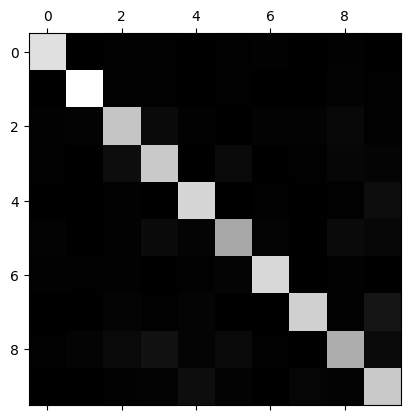

In [43]:
import matplotlib.pyplot as plt

plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

1. 大多数在主对角线上，说明被正确分类，数字5看起来比其他数字稍稍暗一些，这可能意味着数据集中数字5的图片较少，也可能是数字5的执行效果不如其他数字效果好
2. 将混淆矩阵中的每个值除以相应类中的图片数量，这样你比较的就是错误率而不是错误的绝对值（后者对图片数量较多的类不公平

In [44]:
# axis=1表示对每一行进行求和，keepdims=True表示在结果中保留行维度，这样得到的结果是一个二维数组，其中每一行元素的和表示该行所有元素的总和。

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

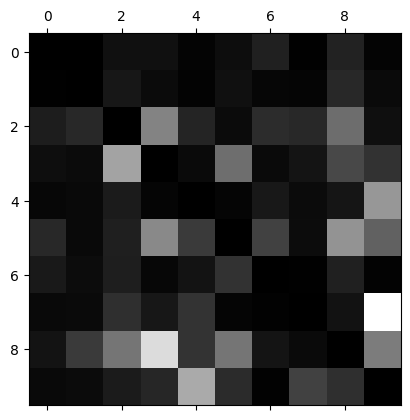

In [45]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

分析混淆矩阵通常可以帮助你深入了解如何改进分类器。通过上图来看，你的精力可以花在改进数字8的分类错误上。

In [46]:
def plot_digits(instances, images_per_row=5, img_shape=(28, 28), **options):
    size = len(instances)
    images_per_row = min(size, images_per_row)
    images = [instance.reshape(img_shape) for instance in instances]
    
    n_rows = (size - 1) // images_per_row + 1
    row_images = []
    
    # Arrange images into rows
    for row in range(n_rows):
        rimages = images[row * images_per_row: (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    
    image = np.concatenate(row_images, axis=0)
    
    # Display the concatenated image
    plt.imshow(image, cmap=plt.cm.binary, **options)
    plt.axis("off")

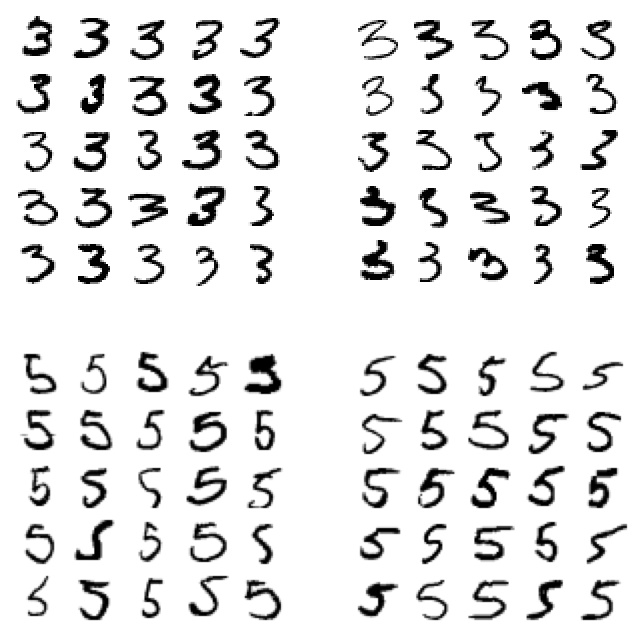

In [47]:
cl_a, cl_b = 3, 5
# X_train是pandas的DataFrame类型，需要将其转换为numpy数据，.values方法可以将DataFrame转化为Numpy数组
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)].values
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)].values
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)].values
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)].values

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

1. 原因在于，我们使用的简单的SGDClassifier模型是一个线性模型。它所做的就是为每个像素分配一个各个类别的权重，当它看到新的图像时，将加权后的像素强度汇总，从而得到一个分数进行分类。而数字3和数字5只在一部分像素位上有区别，所以分类器很容易将其弄混。

2. 数字3和数字5之间的主要区别是在于连接顶线和下方弧线的中间那段小线条的位置。如果你写的数字3将连接点略往左移，分类器就可能将其分类为数字5，反之亦然。换言之，这个分类器对图像移位和旋转非常敏感。

3. 因此，减少数字3和数字5混淆的方法之一，就是对图片进行预处理，确保它们位于中心位置并且没有旋转。这也同样有助于减少其他错误。

#### 多分类标签

In [48]:
from sklearn.neighbors import KNeighborsClassifier

y_train_larger = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_larger, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [49]:
knn_clf.predict([some_digit])

c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

5确实不大，为奇数

#### 评估多分类器
1. 平均F1分数
    - 假设所有的标签都是同等重要
    - 加权标签

In [50]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

In [51]:
from sklearn.metrics import f1_score
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9748370741124373

#### 多输出分类

目标是将图片还原为原始图片

In [52]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

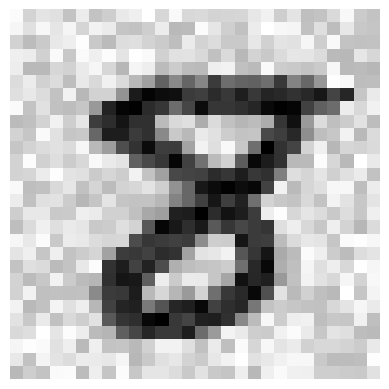

In [53]:
plot_digits([X_test_mod.iloc[some_digit].values[0]])

In [54]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict(X_test_mod.iloc[some_digit].values)


c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


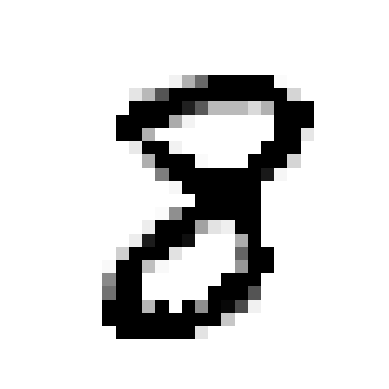

In [55]:
plot_digits([clean_digit[1]], images_per_row=1)


### 练习题

In [56]:
from sklearn.model_selection import train_test_split
# 分测试集和训练集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [57]:
# 创建分类器
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()

# 使用网格搜索
from sklearn.model_selection import GridSearchCV
param_grid = [
    {
        'weights': ['uniform','distance'],
        'n_neighbors': [i for i in range(1, 11)]
    }
]
grid_search = GridSearchCV(knn_clf, param_grid, cv=3, verbose=2)
grid_search.fit(X_train, y_train)
# 输出最佳参数
grid_search.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END .....................n_neighbors=1, weights=uniform; total time=  13.4s
[CV] END .....................n_neighbors=1, weights=uniform; total time=  12.7s
[CV] END .....................n_neighbors=1, weights=uniform; total time=  13.8s
[CV] END ....................n_neighbors=1, weights=distance; total time=  13.3s
[CV] END ....................n_neighbors=1, weights=distance; total time=  13.5s
[CV] END ....................n_neighbors=1, weights=distance; total time=  13.7s
[CV] END .....................n_neighbors=2, weights=uniform; total time=  14.8s
[CV] END .....................n_neighbors=2, weights=uniform; total time=  14.2s
[CV] END .....................n_neighbors=2, weights=uniform; total time=  13.7s
[CV] END ....................n_neighbors=2, weights=distance; total time=  12.9s
[CV] END ....................n_neighbors=2, weights=distance; total time=  13.2s
[CV] END ....................n_neighbors=2, weig

{'n_neighbors': 4, 'weights': 'distance'}

In [58]:
# 找到最佳的参数后，使用最佳参数创建分类器
from sklearn.model_selection import cross_val_score
knn_clf = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn_clf.fit(X_train, y_train)
cross_val_score(knn_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.96945023, 0.96987694, 0.96785649])

In [59]:
# 在测试集上进行测试
knn_clf.score(X_test, y_test)

0.9715714285714285

#### scipy.ndimage.shift
    - The array is **shifted using spline interpolation** of the requested order. Points outside the boundaries of the input are filled according to the given mode.
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.shift.html

In [60]:
import scipy
def move_image(x_train,direction='down'):
    if direction == 'down':
        shift=[5,0]
    elif direction == 'up':
        shift=[-5,0]
    elif direction == 'right':
        shift=[0,5]
    elif direction == 'left':
        shift=[0,-5]
    else:
        print('wrong direction')
    x_train_shifted = scipy.ndimage.shift(x_train,shift,mode='constant',cval=0)
    return x_train_shifted
        

(28, 28)


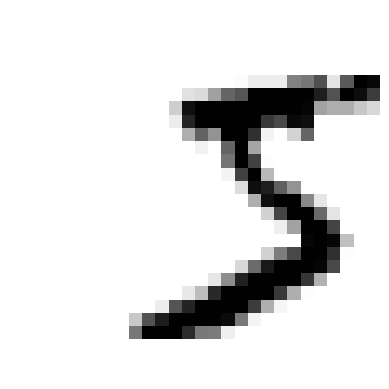

In [61]:
some_digit_shifted = move_image(some_digit.reshape(28,28),direction='right')
print(some_digit_shifted.shape)
plt.imshow(some_digit_shifted, cmap='binary')
plt.axis('off')
plt.show()

In [62]:
X_train_np = X_train.values
y_train_np = y_train.values

n_samples = X_train_np.shape[0]
# 先对整个array进行转换，避免后面dataframe和numpy频繁转换
X_train_reshaped = X_train_np.reshape((n_samples, 28, 28))
shifted_images = [X_train_reshaped]

directions = ['up', 'down','right','left']
for direction in directions:
    shifted = np.array([move_image(img, direction=direction) for img in X_train_reshaped])
    shifted_images.append(shifted)
    
# 将所有平移后的图像堆叠在一起，形状为 (n_samples * 5, 28, 28)
X_train_augmented = np.vstack(shifted_images)

# 将图像重新展开为 (n_samples * 5, 784)
X_train_augmented = X_train_augmented.reshape((-1, 784))

# 生成对应的标签，重复每个标签 5 次
y_train_augmented = np.tile(y_train_np, 5)

print("增强后的训练集形状：", X_train_augmented.shape)
print("增强后的标签集形状：", y_train_augmented.shape)
    

增强后的训练集形状： (245000, 784)
增强后的标签集形状： (245000,)


In [63]:
# import numpy as np
# # 每一行数据表示一张图片
# X_train_shifted = X_train
# y_train_shifted = y_train

# for i in range(len(X_train)):
#     x_train_shifted_piece_down = move_image(X_train.iloc[i].values.reshape((28,28)),direction='down')
#     x_train_shifted_piece_right = move_image(X_train.iloc[i].values.reshape((28,28)),direction='right')
#     x_train_shifted_piece_left = move_image(X_train.iloc[i].values.reshape((28,28)),direction='left')
#     x_train_shifted_piece_up = move_image(X_train.iloc[i].values.reshape((28,28)),direction='up')   
    
#     X_train_shifted = np.insert(X_train_shifted,1,x_train_shifted_piece_down.reshape((784,)))
#     X_train_shifted = np.insert(X_train_shifted,1,x_train_shifted_piece_right.reshape((784,)))
#     X_train_shifted = np.insert(X_train_shifted,1,x_train_shifted_piece_left.reshape((784,)))
#     X_train_shifted = np.insert(X_train_shifted,1,x_train_shifted_piece_up.reshape((784,)))
    
#     y_train_shifted = np.append(y_train, y_train.iloc[i].values, axis = 0)
#     y_train_shifted = np.append(y_train, y_train.iloc[i].values, axis = 0)
#     y_train_shifted = np.append(y_train, y_train.iloc[i].values, axis = 0)
#     y_train_shifted = np.append(y_train, y_train.iloc[i].values, axis = 0)
    


        

#### 增强后的数据训练后效果更好

In [64]:
# 采用增强之后的数据
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
knn_clf = KNeighborsClassifier()

knn_clf.fit(X_train_augmented, y_train_augmented)
cross_val_score(knn_clf,X_train_augmented, y_train_augmented, cv=3, scoring='accuracy')

array([0.48216538, 0.49164289, 0.46485686])

In [65]:
knn_clf.score(X_test, y_test)

c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


0.9672857142857143